In [284]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader

In [285]:
x_data = np.linspace(-100, 100, 30000)
y_data = np.sin(x_data) / x_data

In [286]:
dataset = Dataset(torch.tensor(x_data).float(), torch.tensor(y_data).float())

intersize, testsize = 1001, 3000
interset, trainset, testset = torch.utils.data.random_split(dataset, [intersize, len(dataset)-intersize-testsize, testsize], generator=torch.Generator().manual_seed(42)) # 0.1=3000

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

activation = nn.Sigmoid()

In [287]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(1, 1000, 1)

In [288]:
V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ interset[:][0].reshape(1, -1))
H = torch.concatenate([torch.ones(1, len(interset)), V], dim=0).T
Y = interset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ Y.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [289]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)

In [ ]:
num_epochs = 0
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 1), y.reshape(-1, 1)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')

plt.plot(all_losses)
plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

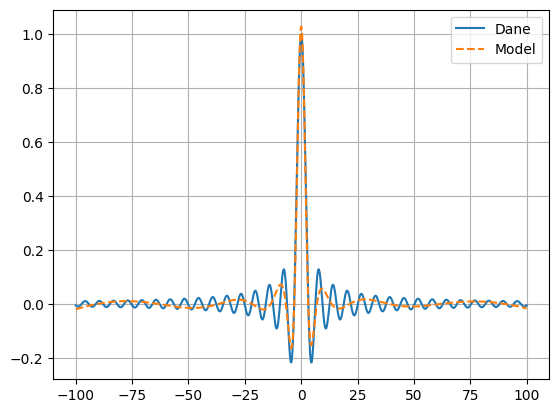

In [293]:
plt.plot(x_data, y_data)
# plt.plot(interset[:][0],interset[:][1], 'xr', markersize=5)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1).float()).detach().numpy(), '--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()